In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [63]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 256


In [64]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = list(idx[:split_point])
test_idx = list(idx[split_point:])

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [65]:
train_dataset[7000][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [66]:
len(train_dataset[0][0])

13322

In [67]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = list(np.concatenate([indices[:start], indices[end:]]))
        trainval_indices = list(indices[start:end])
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        learning_rate = 0.1
        hidden_dim = 512

        # Initialize model and transfer to GPU
        model = MoannaModel(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.4604, Train Acc=0.0994, Val Acc=0.1137, Test Acc=0.1162
Fold 1/5, Epoch 2: Train Loss=3.3824, Train Acc=0.1250, Val Acc=0.1418, Test Acc=0.1396
Fold 1/5, Epoch 3: Train Loss=3.3046, Train Acc=0.1583, Val Acc=0.1542, Test Acc=0.1474
Fold 1/5, Epoch 4: Train Loss=3.2291, Train Acc=0.1711, Val Acc=0.1634, Test Acc=0.1544
Fold 1/5, Epoch 5: Train Loss=3.1629, Train Acc=0.1816, Val Acc=0.1785, Test Acc=0.1683
Fold 1/5, Epoch 6: Train Loss=3.1050, Train Acc=0.1958, Val Acc=0.1785, Test Acc=0.1683
Fold 1/5, Epoch 7: Train Loss=3.0527, Train Acc=0.2024, Val Acc=0.1857, Test Acc=0.1766
Fold 1/5, Epoch 8: Train Loss=3.0004, Train Acc=0.2178, Val Acc=0.1759, Test Acc=0.1725
Fold 1/5, Epoch 9: Train Loss=2.9492, Train Acc=0.2297, Val Acc=0.1948, Test Acc=0.1799
Fold 1/5, Epoch 10: Train Loss=2.8989, Train Acc=0.2377, Val Acc=0.2125, Test Acc=0.2040
Fold 1/5, Epoch 11: Train Loss=2.8469, Train Acc=0.2525, Val Acc=0.2144, Test Acc=0.2069
Fold 1/

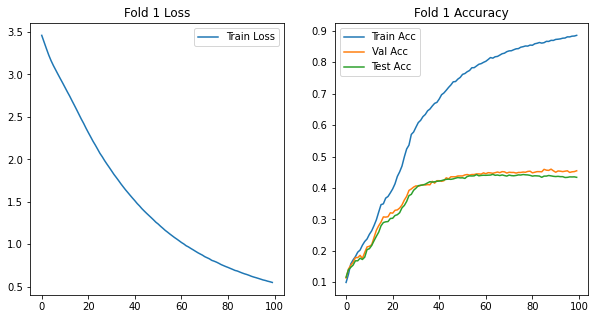

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4638, Train Acc=0.0895, Val Acc=0.1098, Test Acc=0.1129
Fold 2/5, Epoch 2: Train Loss=3.3831, Train Acc=0.1181, Val Acc=0.1319, Test Acc=0.1274
Fold 2/5, Epoch 3: Train Loss=3.2999, Train Acc=0.1558, Val Acc=0.1501, Test Acc=0.1463
Fold 2/5, Epoch 4: Train Loss=3.2239, Train Acc=0.1789, Val Acc=0.1671, Test Acc=0.1614
Fold 2/5, Epoch 5: Train Loss=3.1580, Train Acc=0.1941, Val Acc=0.1776, Test Acc=0.1733
Fold 2/5, Epoch 6: Train Loss=3.0997, Train Acc=0.2035, Val Acc=0.1821, Test Acc=0.1729
Fold 2/5, Epoch 7: Train Loss=3.0466, Train Acc=0.2115, Val Acc=0.1926, Test Acc=0.1867
Fold 2/5, Epoch 8: Train Loss=2.9948, Train Acc=0.2209, Val Acc=0.1887, Test Acc=0.1825
Fold 2/5, Epoch 9: Train Loss=2.9436, Train Acc=0.2300, Val Acc=0.1985, Test Acc=0.1904
Fold 2/5, Epoch 10: Train Loss=2.8917, Train Acc=0.2431, Val Acc=0.2037, Test Acc=0.1903
Fold 2/5, Epoch 11: Train Loss=2.8406, Train Acc=0.2531, Val Acc=0.1972, Test Acc=0.1966
Fold 2/

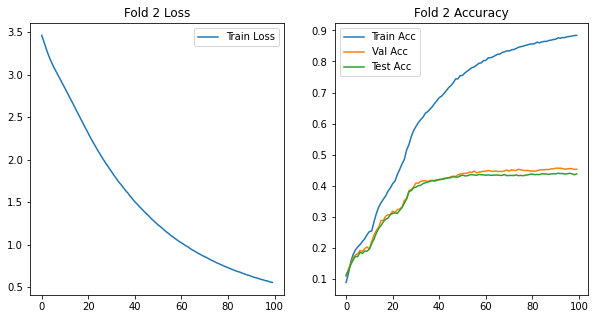

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.4668, Train Acc=0.0965, Val Acc=0.1100, Test Acc=0.1281
Fold 3/5, Epoch 2: Train Loss=3.3845, Train Acc=0.1345, Val Acc=0.1237, Test Acc=0.1387
Fold 3/5, Epoch 3: Train Loss=3.3008, Train Acc=0.1554, Val Acc=0.1302, Test Acc=0.1448
Fold 3/5, Epoch 4: Train Loss=3.2237, Train Acc=0.1686, Val Acc=0.1420, Test Acc=0.1565
Fold 3/5, Epoch 5: Train Loss=3.1586, Train Acc=0.1802, Val Acc=0.1519, Test Acc=0.1644
Fold 3/5, Epoch 6: Train Loss=3.1014, Train Acc=0.1948, Val Acc=0.1577, Test Acc=0.1686
Fold 3/5, Epoch 7: Train Loss=3.0485, Train Acc=0.2035, Val Acc=0.1649, Test Acc=0.1756
Fold 3/5, Epoch 8: Train Loss=2.9956, Train Acc=0.2136, Val Acc=0.1773, Test Acc=0.1889
Fold 3/5, Epoch 9: Train Loss=2.9457, Train Acc=0.2281, Val Acc=0.1656, Test Acc=0.1787
Fold 3/5, Epoch 10: Train Loss=2.8967, Train Acc=0.2354, Val Acc=0.1799, Test Acc=0.1931
Fold 3/5, Epoch 11: Train Loss=2.8435, Train Acc=0.2466, Val Acc=0.1818, Test Acc=0.1987
Fold 3/

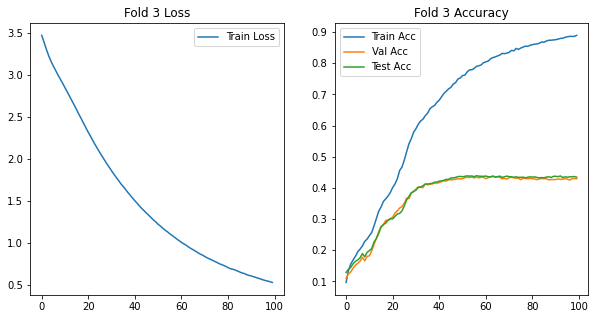

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.4642, Train Acc=0.1031, Val Acc=0.1328, Test Acc=0.1192
Fold 4/5, Epoch 2: Train Loss=3.3858, Train Acc=0.1331, Val Acc=0.1491, Test Acc=0.1397
Fold 4/5, Epoch 3: Train Loss=3.3067, Train Acc=0.1437, Val Acc=0.1517, Test Acc=0.1417
Fold 4/5, Epoch 4: Train Loss=3.2332, Train Acc=0.1578, Val Acc=0.1543, Test Acc=0.1422
Fold 4/5, Epoch 5: Train Loss=3.1695, Train Acc=0.1700, Val Acc=0.1825, Test Acc=0.1619
Fold 4/5, Epoch 6: Train Loss=3.1101, Train Acc=0.1890, Val Acc=0.1878, Test Acc=0.1696
Fold 4/5, Epoch 7: Train Loss=3.0567, Train Acc=0.2061, Val Acc=0.1937, Test Acc=0.1728
Fold 4/5, Epoch 8: Train Loss=3.0049, Train Acc=0.2134, Val Acc=0.2087, Test Acc=0.1858
Fold 4/5, Epoch 9: Train Loss=2.9542, Train Acc=0.2211, Val Acc=0.2159, Test Acc=0.1954
Fold 4/5, Epoch 10: Train Loss=2.9049, Train Acc=0.2323, Val Acc=0.2256, Test Acc=0.2033
Fold 4/5, Epoch 11: Train Loss=2.8496, Train Acc=0.2534, Val Acc=0.2361, Test Acc=0.2178
Fold 4/

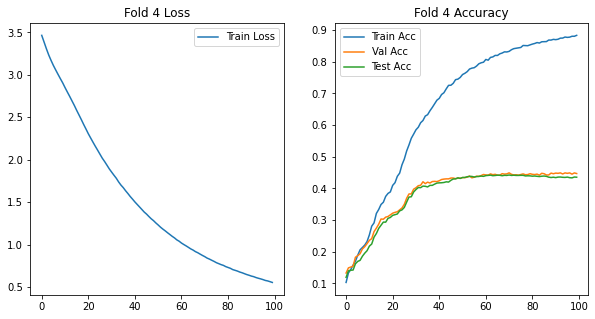

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.4634, Train Acc=0.0785, Val Acc=0.1352, Test Acc=0.1326
Fold 5/5, Epoch 2: Train Loss=3.3791, Train Acc=0.1424, Val Acc=0.1541, Test Acc=0.1532
Fold 5/5, Epoch 3: Train Loss=3.2938, Train Acc=0.1599, Val Acc=0.1679, Test Acc=0.1654
Fold 5/5, Epoch 4: Train Loss=3.2180, Train Acc=0.1809, Val Acc=0.1686, Test Acc=0.1632
Fold 5/5, Epoch 5: Train Loss=3.1524, Train Acc=0.1973, Val Acc=0.1619, Test Acc=0.1636
Fold 5/5, Epoch 6: Train Loss=3.0968, Train Acc=0.2013, Val Acc=0.1737, Test Acc=0.1739
Fold 5/5, Epoch 7: Train Loss=3.0468, Train Acc=0.2101, Val Acc=0.1881, Test Acc=0.1814
Fold 5/5, Epoch 8: Train Loss=2.9979, Train Acc=0.2213, Val Acc=0.1875, Test Acc=0.1865
Fold 5/5, Epoch 9: Train Loss=2.9441, Train Acc=0.2381, Val Acc=0.1856, Test Acc=0.1805
Fold 5/5, Epoch 10: Train Loss=2.8943, Train Acc=0.2429, Val Acc=0.1967, Test Acc=0.2014
Fold 5/5, Epoch 11: Train Loss=2.8443, Train Acc=0.2554, Val Acc=0.2098, Test Acc=0.2094
Fold 5/

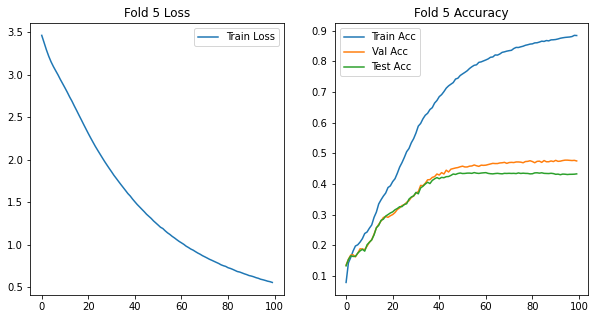

In [68]:
num_epochs = 100
k = 5

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device=device, shuffle=True)

In [69]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=512, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=512, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=512, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=512, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=512, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=512, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=512, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=512, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=512, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=51

In [70]:
Train_acc

[0.8854528489602503,
 0.8840647428229665,
 0.8895495951417004,
 0.8833286368237026,
 0.8838483679149797]

In [71]:
Val_acc

[0.4546614583333333, 0.45360416666666664, 0.429359375, 0.447, 0.47475]

In [72]:
Test_acc

[0.4338399561125212,
 0.43855918200084604,
 0.43422992015651435,
 0.435401464678511,
 0.4325692681895093]

In [73]:
TRAIN_acc = np.mean(Train_acc)
print(f"{TRAIN_acc:.4f}")

0.8852


In [74]:
VAL_acc = np.mean(Val_acc)
print(f"{VAL_acc:.4f}")

0.4519


In [75]:
TEST_acc = np.mean(Test_acc)
print(f"{TEST_acc:.4f}")

0.4349


In [76]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [77]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.4338
Test Accuracy: 0.4386
Test Accuracy: 0.4342
Test Accuracy: 0.4354
Test Accuracy: 0.4326


In [78]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([ 0, 27, 10,  0, 16, 13, 21,  6, 27,  0, 29, 32, 24, 18, 24, 21,  4,  1,
         7, 27,  4, 13,  1, 11, 15, 10,  4,  1,  1, 27, 18,  7,  1, 11, 22, 27,
        16,  1, 19, 18, 15, 27, 25, 22, 24, 25, 22, 11,  4,  1,  1, 27, 16,  4,
         0, 16,  1, 23, 15, 29, 21, 25,  1, 14, 30, 10,  7, 21, 11,  4, 18, 25,
        15, 11,  7, 13,  1,  1, 11,  2,  7, 29, 18,  1, 21,  7, 24,  1, 15,  0,
         1, 14,  2,  8, 11,  7, 10, 18,  1,  7, 23, 27,  7, 11, 27,  6, 23, 18,
        11,  4, 10,  8, 10, 21, 27,  2,  1, 18,  0, 23,  4, 22, 27, 27,  1, 10,
         1, 21, 16, 27, 14,  0, 29,  1, 23, 18, 29, 27, 13,  7,  4, 15,  1, 25,
         7, 27,  8, 31, 15, 14, 27, 16, 24, 21, 15, 18, 23, 27, 27,  4, 27, 16,
        27,  6,  8, 15, 29, 10,  4, 25, 21, 10, 13,  8,  7,  4,  7, 27, 15, 21,
        29, 11, 25,  7, 15,  8,  7, 27, 29, 29, 18, 19, 24, 15,  8,  4,  4,  1,
        24, 10,  1, 14, 15, 25, 15, 24, 18, 13, 15, 29, 15, 13, 27, 22, 25, 25,
        14, 15,  7, 29, 27, 29, 18, 14, 